In [1]:
import import_ipynb
import i_creation_environnement
import numpy as np
import matplotlib.pyplot as plt

importing Jupyter notebook from i_creation_environnement.ipynb


In [2]:
env = i_creation_environnement.AugmentedGridworldEnv()

# Value Iteration

In [3]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    for i in range(10000):
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            print("")
            print(" --------- >       VALUE FUNCTION STABLE")
            break
            
        if i%30==0:
            print("Step :", i, "     Delta : ", delta)
            plt.imshow(V.reshape(env.shape))
            plt.show()
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

Step : 0      Delta :  99.5


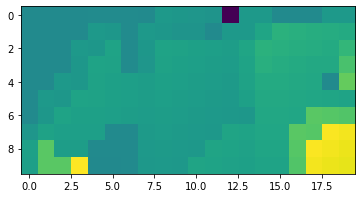

Step : 30      Delta :  36.98501866941433


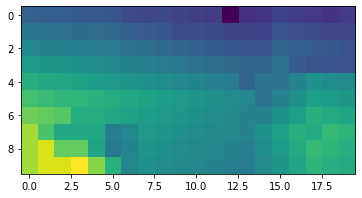

Step : 60      Delta :  27.357832119538216


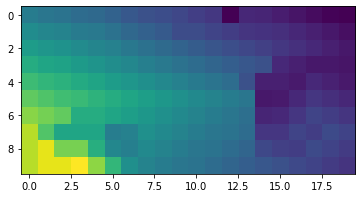

Step : 90      Delta :  20.236598633916856


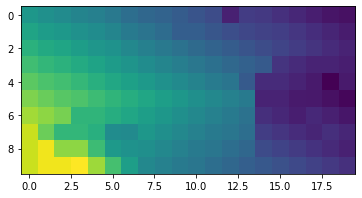

Step : 120      Delta :  14.96901956561669


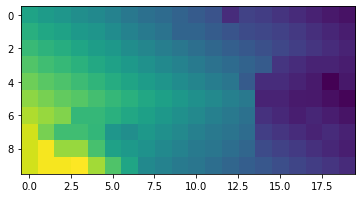

Step : 150      Delta :  11.072589361943756


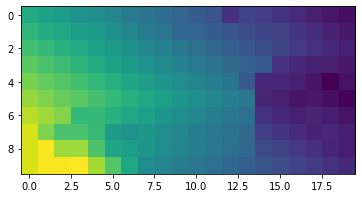

Step : 180      Delta :  8.190398485404785


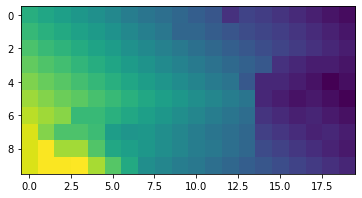

Step : 210      Delta :  6.058440817853352


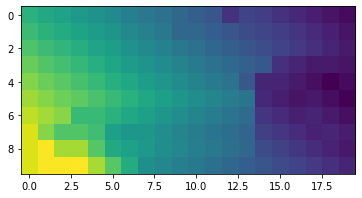

Step : 240      Delta :  4.481430935117714


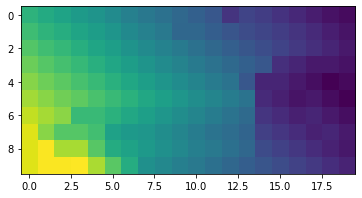

Step : 270      Delta :  3.3149161360206563


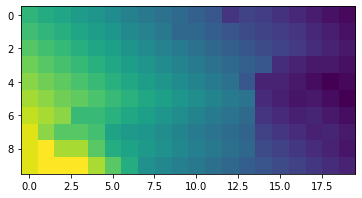

Step : 300      Delta :  2.4520447035656616


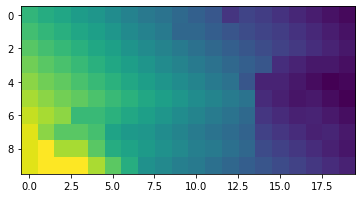

Step : 330      Delta :  1.8137783827924068


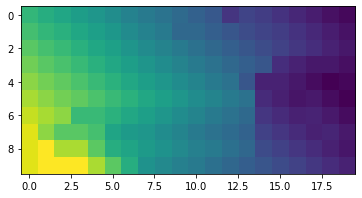

Step : 360      Delta :  1.3416525469947373


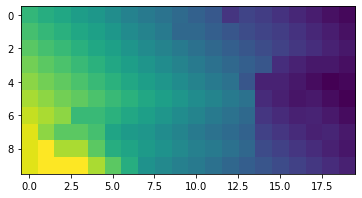

Step : 390      Delta :  0.9924208899701625


KeyboardInterrupt: 

In [4]:
policy_1, v_1 = value_iteration(env, discount_factor = 0.99)

### Final results for Value Iteration

In [ ]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print("")
env.render_policy(np.reshape(np.argmax(policy_1, axis=1), env.shape))
print("")

print("Value Function:")
plt.imshow(v_1.reshape(env.shape))
print("")

# Policy Evaluation

In [ ]:
def policy_eval(policy, env, discount_factor=0.999, theta=0.000001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    
    # Start with a random (all 0) value function

    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):  # for all the states
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    
                    # Calculate the expected value. Ref: Sutton book eq. 4.6.
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
                    
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
            
        # Stop evaluating once our value function change is below a threshold
        #print(delta)
        if delta < theta:
            break
    return np.array(V), delta

In [ ]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v, delta = policy_eval(random_policy, env, 1)

In [ ]:
print("Reshaped Grid Value Function:")
vv = v.reshape(env.shape)

np.set_printoptions( threshold=20, edgeitems=10, linewidth=140,formatter = dict( float = lambda x: "%.3g" % x )) 

print(np.around(vv, 1))

In [ ]:
plt.imshow(vv)

# Policy Iteration

In [ ]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    
    

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    ancient_V = np.zeros(env.nS)

    #while True:
    for i in range(30):
        
        # Evaluate the current policy
        V, delta = policy_eval_fn(policy, env, discount_factor)
        print("###############################    STEP  : ", i, "   ##############################")
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable :
            print("")
            print("----------> STABLE POLICY")
            return policy, V
        
        print("")
        print("CURRENT POLICY")
        env.render_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
        print("")
        
        print("DIFFERENCES WITH PREVIOUS VALUE FUNCTION")
        plt.imshow(np.reshape(V - ancient_V, env.shape))
        plt.show()
        print("")
        
        print("CURRENT VALUE FUNCTION")
        plt.imshow(np.reshape(V, env.shape))
        plt.show()
        print("")
        print("")
        
    
        ancient_V = V
        
        #rint(np.reshape(np.argmax(policy, axis=1), env.shape))
        #rint(V.reshape(env.shape))
        
    return policy, V

In [ ]:
policy_2, v_2 = policy_improvement(env, discount_factor = 0.99)

### Final results for Policy Iteration

In [ ]:
print("Final policy")
print("")
env.render_policy(np.reshape(np.argmax(policy_2, axis=1), env.shape))

print("Final Value Function:")
plt.imshow(v_2.reshape(env.shape))

## Comments : 
- With a discount rate of 0.95, the policy is stable at the end... it's not the case with smaller discount rates (like 0.9 for example). 
- We need 16 steps to get the optimal policy and we therefore can say that the initial value function estimation (found with the random policy) wasn't the optimal one. 


In [ ]:
plt.imshow((v_2 - v_1).reshape(env.shape))
plt.colorbar()

- the value function given by Policy Iteration slightly differs from the one given by Value Iteration

In [ ]:
np.reshape(np.argmax(policy_2, axis=1) - np.argmax(policy_1, axis=1), env.shape)

#### - But policies are the same ! 